# Reduced-dimension Emulator: Reaction-Diffusion example

### Overview
In this example, we aim to create an _emulator_ to generate solutions to a 2D parameterized reaction-diffusion problem governed by the following partial differential equations:

$$
\dot{u} = (1 - (u^2 + v^2)) u + \beta (u^2 + v^2) v + d (u_{xx} + u_{yy}),
$$
$$
\dot{v} = -\beta (u^2 + v^2) u + (1 - (u^2 + v^2)) v + d (v_{xx} + v_{yy}),
$$

where:
- $ u $ and $ v $ are the concentrations of two species,
- $ \beta $ and $ d $ control the reaction and diffusion terms.

This system exhibits complex spatio-temporal dynamics such as spiral waves.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import autoemulate as ae
from tqdm import tqdm

from autoemulate.experimental_design import LatinHypercube
from autoemulate.simulations.reactiondiffusion import simulate_reactiondiffusion
from autoemulate.compare import AutoEmulate

/Users/pconti/Desktop/AutoEmulator/autoemulate/autoemulate/compare.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### 1) Data generation
Data are computed using a numerical [_simulator_](https://github.com/dynamicslab/pysindy/blob/master/examples/10_PDEFIND_examples.ipynb) using Fourier spectral method.
The simulator takes two inputs: the reaction parameter $\beta$ and the diffusion parameter $d$.

We sample 80 sets of inputs `X` using Latin Hypercube sampling and run the simulator for those inputs to get the solutions `Y`.


In [2]:
seed = 42
np.random.seed(seed)

beta = (1., 2.) # lower and upper bounds for the reaction coefficient
d = (0.05, 0.3) # lower and upper bounds for the diffusion coefficient
lhd = LatinHypercube([beta, d])
n_samples = 50
n = 16
X = lhd.sample(n_samples)
U, V = zip(*[simulate_reactiondiffusion(x, n=n, T=5) for x in tqdm(X)])
U = np.stack(U)
V = np.stack(V)

# Let's consider as output the concentration of the specie U
Y = U.reshape(n_samples, -1)

print(f"shapes: input X: {X.shape}, output Y: {Y.shape}\n")

100%|██████████| 50/50 [00:15<00:00,  3.19it/s]

shapes: input X: (50, 2), output Y: (50, 256)



`X` and `Y` are matrices where each row represents one run of the simulation.  In the input matrix `X` each column is a different input parameters. 
In the output matrix `Y` each column indicates a spatial location where the solution (i.e. the concentration of $U$ at final time $T$) is computed. <br>
We consider a 2D spatial grid of $32\times 32$ points, therefore each row of `Y` corresponds to a 1024-dimensional vector!

Let’s now plot the simulated data to see how the reaction-diffusion pattern looks like.

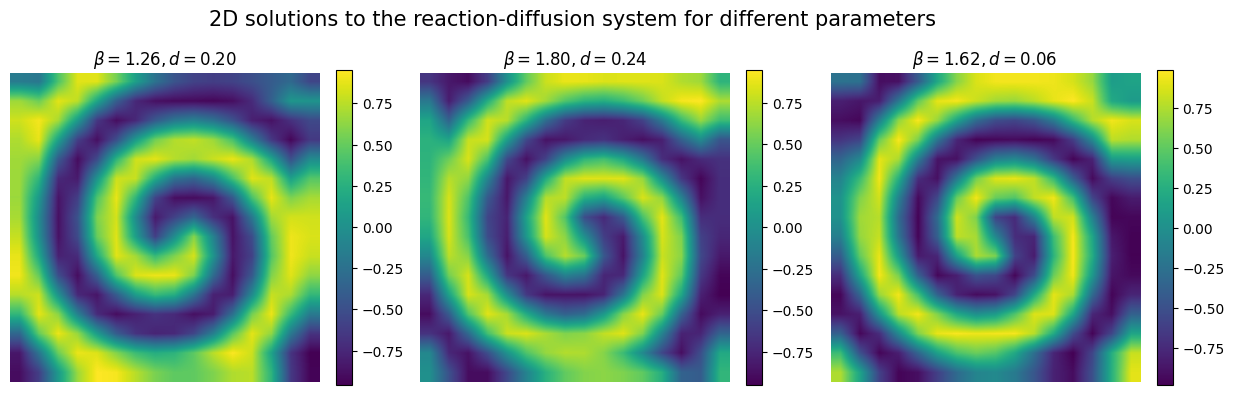

In [3]:
plt.figure(figsize=(15,4.5))
for param in range(3):
  plt.subplot(1,3,1+param)
  plt.imshow(U[param], interpolation='bilinear')
  plt.axis('off')
  plt.xlabel('x', fontsize=12)
  plt.ylabel('y')
  plt.title(r'$\beta = {:.2f}, d = {:.2f}$'.format(X[param][0], X[param][1]), fontsize=12)
  plt.colorbar(fraction=0.046)
plt.suptitle('2D solutions to the reaction-diffusion system for different parameters', fontsize=15)
plt.show()

## 2) Reduced-dimension Emulator
The numerical simulator is computationally expensive to run, thus we aim to replace it with a fast _emulator_.
As output we aim to emulate is the full spatial fields of the concentration of $U$ which is high-dimensional, we employ dimensionality reduction techniques to create a faster and more efficient emulator.

You can do so by selecting `reduce_dim_output=True` and indicate which dimensionality reducer `dim_reducer_output` you want to use among:
- `"PCA"`: Principal Component Analysis (deafult),
- `"AE"`: Autoencoder,
- `"VAE"`: Variational Autoencoder,

which will be trained together with the emulator.

In [23]:
em = AutoEmulate()
em.setup(X, Y, models=["gp"], reduce_dim_output=True, dim_reducer_output = 'VAE')
best_model = em.compare()

,Values
Simulation input shape (X),"(50, 2)"
Simulation output shape (y),"(50, 256)"
Proportion of data for testing (test_set_size),0.2
Scale input data (scale),True
Scaler (scaler),StandardScaler
Do hyperparameter search (param_search),False
Reduce input dimensionality (reduce_dim),False
Reduce output dimensionality (reduce_dim_output),True
Dimensionality output reduction method (dim_reducer_output),VAE
Cross validator (cross_validator),KFold


Initializing:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 10/100, Loss: 3291.8169
Epoch 20/100, Loss: 3000.0686
Epoch 30/100, Loss: 2533.0151
Epoch 40/100, Loss: 2215.4998
Epoch 50/100, Loss: 1577.2125
Epoch 60/100, Loss: 972.5111
Epoch 70/100, Loss: 611.1912
Epoch 80/100, Loss: 461.2450
Epoch 90/100, Loss: 366.4953
Epoch 100/100, Loss: 317.2126
Epoch 10/100, Loss: 3138.5605
Epoch 20/100, Loss: 2664.2173
Epoch 30/100, Loss: 2207.9402
Epoch 40/100, Loss: 1592.8962
Epoch 50/100, Loss: 938.5061
Epoch 60/100, Loss: 619.2587
Epoch 70/100, Loss: 464.5008
Epoch 80/100, Loss: 370.6586
Epoch 90/100, Loss: 340.5800
Epoch 100/100, Loss: 293.0690
Epoch 10/100, Loss: 3230.9480
Epoch 20/100, Loss: 2894.4653
Epoch 30/100, Loss: 2343.7891
Epoch 40/100, Loss: 1489.5065
Epoch 50/100, Loss: 876.0775
Epoch 60/100, Loss: 614.1674
Epoch 70/100, Loss: 483.4574
Epoch 80/100, Loss: 432.5054
Epoch 90/100, Loss: 353.9450
Epoch 100/100, Loss: 339.6868
Epoch 10/100, Loss: 3163.6709
Epoch 20/100, Loss: 2859.9465
Epoch 30/100, Loss: 2314.0176
Epoch 40/100, Loss: 1654

In [24]:
best_model

AutoEmulatePipeline(steps=[('Dimentionality reducer for output ',
                            VAEOutputPreprocessor(device='cpu',
                                                  hidden_dims=[64, 32],
                                                  verbose=True)),
                           ('scaler', StandardScaler()),
                           ('model', GaussianProcess())])

## 3) Summarising cross-validation results
We can look at the cross-validation results to see which model provides the best emulator. 

In [26]:
em.summarise_cv()

,model,short,rmse,r2
0,GaussianProcess,gp,0.028392,0.995436
1,RadialBasisFunctions,rbf,0.046672,0.986894
2,SupportVectorMachines,svm,0.094358,0.952983
3,ConditionalNeuralProcess,cnp,0.099483,0.917535
4,SecondOrderPolynomial,sop,0.171278,0.880519
5,RandomForest,rf,0.213836,0.784933
6,GradientBoosting,gb,0.224825,0.768743
7,LightGBM,lgbm,0.571669,-0.175519


We can select the best performing emulator model (in this case GaussianProcess) and see how it performs on the test-set, which AutoEmulate automatically sets aside.

We can plot the test-set performance for chosen emulator.

In [27]:
## 3) Evaluate the emulator (on the test set)
gp = em.get_model('GaussianProcess')
em.evaluate(gp)

,model,short,rmse,r2
0,GaussianProcess,gp,0.0143,0.9987


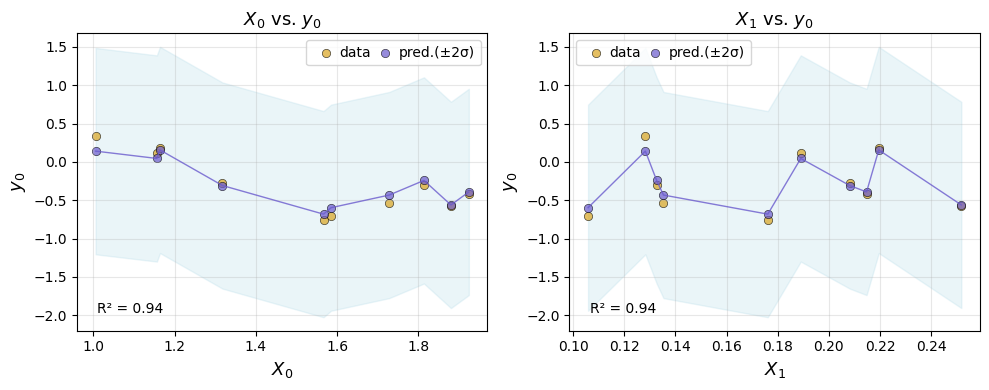

In [35]:
em.plot_eval(gp, input_index=[0,1])

## 4) Refitting the model on the full dataset
AutoEmulate splits the dataset into a training and holdout set. All cross-validation, parameter optimisation and model selection is done on the training set. After we selected a best emulator model, we can refit it on the full traiing dataset.

In [19]:
gp_final = em.refit(gp)

Epoch 10/100, Loss: 2232.8808
Epoch 20/100, Loss: 1699.4697
Epoch 30/100, Loss: 667.5791
Epoch 40/100, Loss: 331.2649
Epoch 50/100, Loss: 242.8078
Epoch 60/100, Loss: 217.4926
Epoch 70/100, Loss: 213.6804
Epoch 80/100, Loss: 207.5106
Epoch 90/100, Loss: 222.3033
Epoch 100/100, Loss: 201.1251


## 5) Predict on the test set
Now we run the emulator for unseen combinations of reaction and diffusion parameter and we compare its performance with respect to the reference (simulator)

In [20]:
y_pred = gp_final.predict(X[em.test_idxs])
y_true = Y[em.test_idxs]

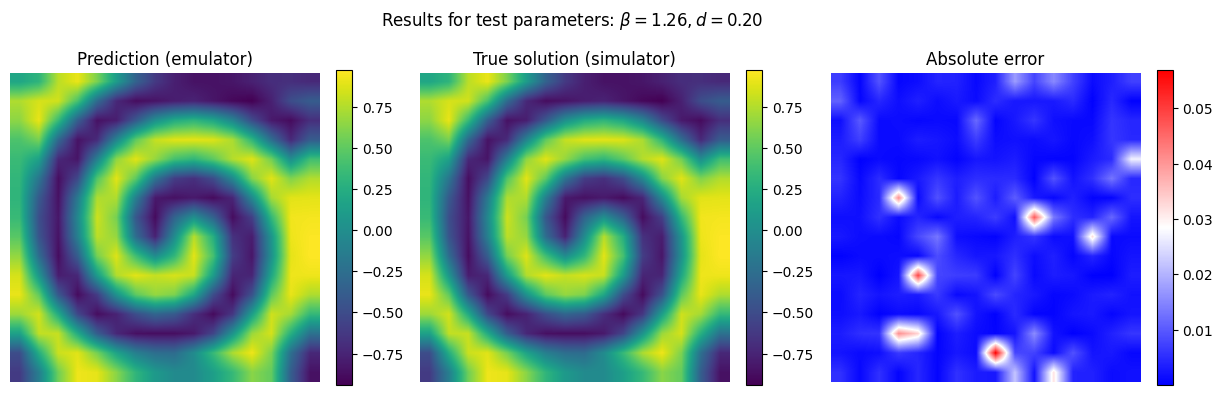

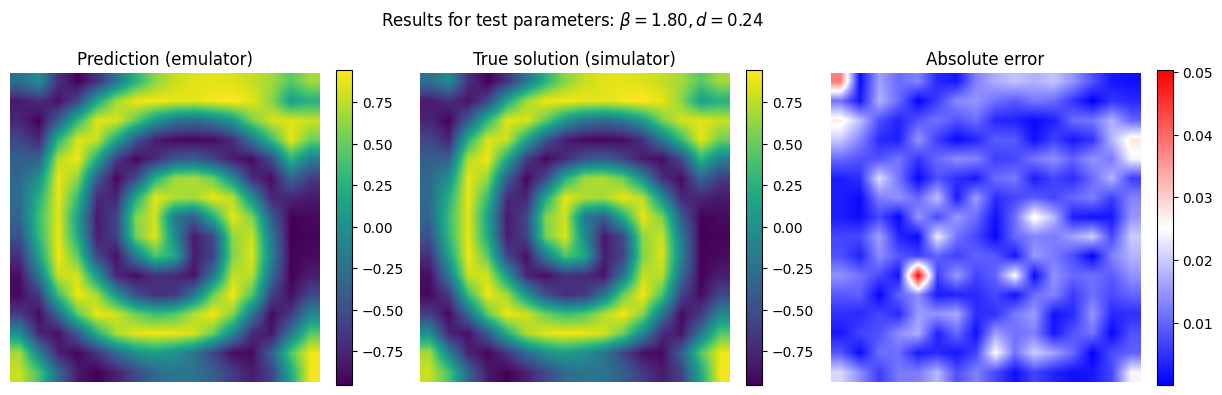

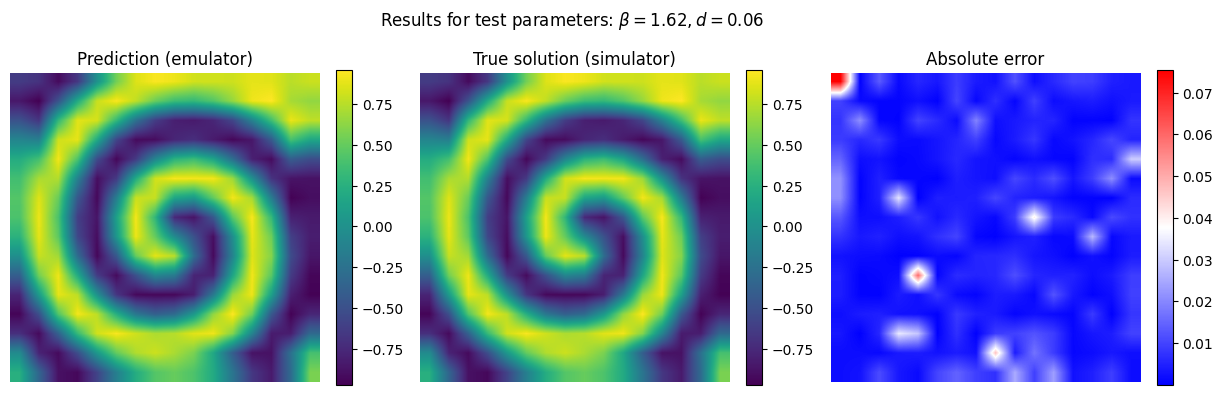

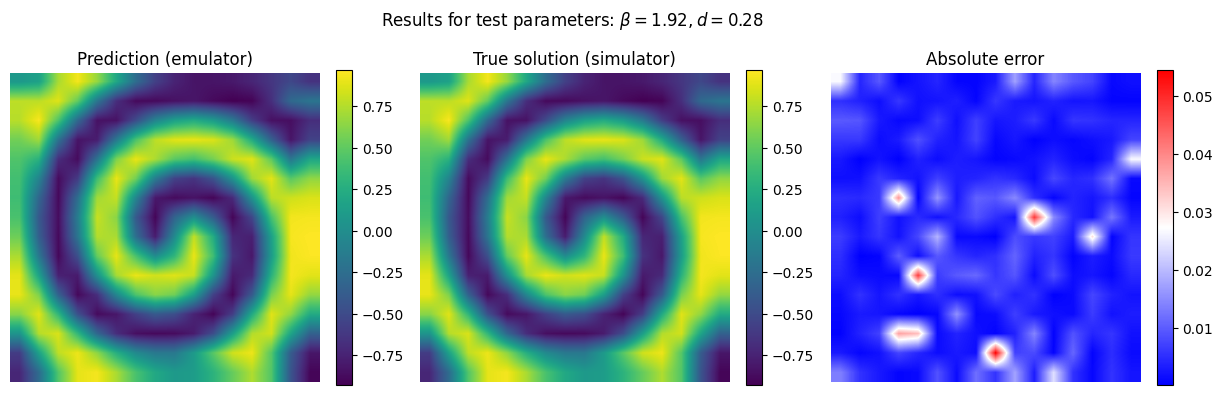

In [21]:
# Plot the results for some unseen (test) parameter instances
params_test = [0,1,2,3]

for param_test in params_test:
  plt.figure(figsize=(15,4.5))
  plt.subplot(1,3,1)
  plt.imshow(y_pred[param_test].reshape(n,n), interpolation='bilinear')
  plt.axis('off')
  plt.xlabel('x', fontsize=12)
  plt.ylabel('y')
  plt.title('Prediction (emulator)', fontsize=12)
  plt.colorbar(fraction=0.046)

  plt.subplot(1,3,2)
  plt.imshow(y_pred[param_test].reshape(n,n), interpolation='bilinear')
  plt.axis('off')
  plt.xlabel('x', fontsize=12)
  plt.ylabel('y')
  plt.title('True solution (simulator)', fontsize=12)
  plt.colorbar(fraction=0.046)

  plt.subplot(1,3,3)
  plt.imshow(np.abs(y_pred[param_test] - y_true[param_test]).reshape(n,n), cmap = 'bwr', interpolation='bilinear')
  plt.axis('off')
  plt.xlabel('x', fontsize=12)
  plt.ylabel('y')
  plt.title('Absolute error', fontsize=12)
  plt.colorbar(fraction=0.046)

  plt.suptitle(r'Results for test parameters: $\beta = {:.2f}, d = {:.2f}$'.format(X[param_test][0], X[param_test][1]), fontsize=12)
  plt.show()